In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import os
import cv2
import numpy as np
import torch
import json

In [23]:
file_path = Path.cwd().parent/"test.csv"
annotations_path = Path.cwd().parent/"test_annotations.json"
with open(annotations_path, "r") as stream:
    annotations = json.load(stream)
test_df = pd.read_csv(file_path)
test_df.head()

,image_id,bboxes
0,aac893a91,"[[95.0, 76.0, 71.0, 78.0], [236.0, 97.0, 134.0..."
1,348a992bb,"[[137.0, 42.0, 112.0, 83.0], [534.0, 42.0, 79...."
2,51f1be19e,"[[33.0, 4.0, 60.0, 67.0], [0.0, 377.0, 45.0, 1..."
3,53f253011,"[[19.0, 39.0, 126.0, 107.0], [159.0, 111.0, 58..."
4,cc3532ff6,"[[0.0, 192.0, 15.0, 82.0], [12.0, 351.0, 100.0..."


In [24]:
images = annotations["images"]
annotations = annotations["annotations"]

In [25]:
idtopath = {im["id"]:im["path"].split("/")[-1].split(".")[0] for im in images}
images_id = [idtopath[ann["image_id"]] for ann in annotations]
bboxes = [ann["bbox"] for ann in annotations]

In [26]:
data = {"image_id": images_id, "bbox": bboxes}
df = pd.DataFrame.from_dict(data)
df.head()


,image_id,bbox
0,aac893a91,"[82.0, 0.0, 80.0, 154.0]"
1,aac893a91,"[236.0, 97.0, 134.0, 128.0]"
2,aac893a91,"[551.0, 79.0, 136.0, 169.0]"
3,aac893a91,"[347.0, 272.0, 109.0, 139.0]"
4,aac893a91,"[20.0, 459.0, 109.0, 151.0]"


In [27]:
def get_bboxes_areas(row_box):
    bbox = np.array(row_box)
    x, y, w, h = bbox
    return x, y, x+w, y+h, w*h

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1
df['area'] = 0
df[['xmin', 'ymin', 'xmax', 'ymax', 'area']] = np.stack(df['bbox'].apply(lambda row_box: get_bboxes_areas(row_box)))
df.drop(columns=["bbox"], inplace=True)
df.head()

,image_id,xmin,ymin,xmax,ymax,area
0,aac893a91,82.0,0.0,162.0,154.0,12320.0
1,aac893a91,236.0,97.0,370.0,225.0,17152.0
2,aac893a91,551.0,79.0,687.0,248.0,22984.0
3,aac893a91,347.0,272.0,456.0,411.0,15151.0
4,aac893a91,20.0,459.0,129.0,610.0,16459.0


In [34]:
df.to_csv("../test_df.csv", index=False)

In [28]:
class AnnotatedTestDataset(Dataset):
    def __init__(self, test_df, root_dir, transforms):
        self.df = test_df
        self.image_ids = self.df.image_id.unique()
        self.root_dir = root_dir
        self.transforms = transforms

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_path = os.path.join(self.root_dir, image_id+".jpg")
        image = self.load_image(image_path)

        bboxes_areas = self.df[self.df.image_id==image_id][["xmin", "ymin", "xmax", "ymax", "area"]].values#.astype(np.float)
        #bboxes_areas = torch.as_tensor(bboxes_areas, dtype=torch.float32)  
        bboxes = bboxes_areas[:, :-1]
        area = torch.as_tensor(bboxes_areas[:, -1])

#         bboxes_str = self.df.iloc[index]["bboxes"]
#         bboxes_str = [b+"]" for b in bboxes_str[1:-1].split("],")]
#         bboxes = np.array([np.fromstring(box.strip()[1:-1], sep=",") for box in bboxes_str])
#         areas = bboxes[:, 2] * bboxes[:, 3]
#         area = torch.as_tensor(areas)
#         bboxes[:,2] = bboxes[:, 0] + bboxes[:,2]
#         bboxes[:,3] = bboxes[:, 1] + bboxes[:,3]
        
        labels = torch.ones(len(bboxes), dtype=torch.int64)
        image_id = torch.as_tensor([index], dtype=torch.int64)
        iscrowd = torch.zeros(len(bboxes), dtype=torch.uint8)

        target = {"boxes": bboxes,
                  "labels": labels,
                  "image_id": image_id,
                  "area": area,
                  "iscrowd": iscrowd,
          }
        
        sample = self.transforms(**{"image": image,
                                    "bboxes": bboxes,
                                    "labels": labels})

        target["boxes"] = torch.as_tensor(sample["bboxes"], dtype=torch.float32).reshape(-1, 4)
        image = sample["image"]
        return image, target


    def __len__(self,):
        return len(self.df)

    def load_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
#         image = Image.open(image_path).convert("RGB")
        return image
    
def collate_fn(sample):
    return tuple(zip(*sample))

In [29]:
transforms = A.Compose([
#     A.Resize(height=800, width=800, p=1.0),
    ToTensorV2(p=1),
    ],
    p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
)

In [30]:
annotatedataset = AnnotatedTestDataset(df, "../test", transforms)
dloader = DataLoader(annotatedataset, batch_size=4, collate_fn=collate_fn)

In [31]:
batch = next(iter(dloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


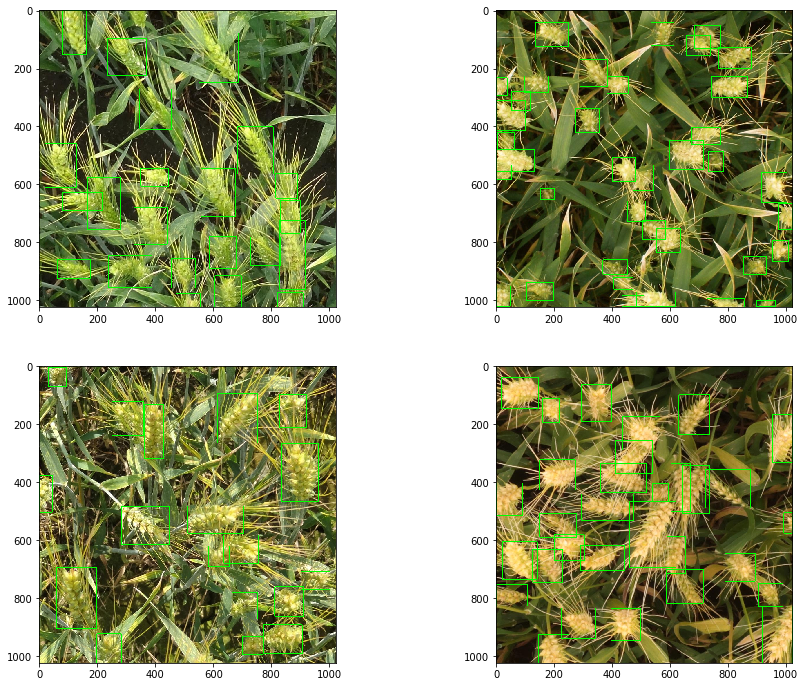

In [32]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.reshape(2*2)

batch = next(iter(dloader))

for i ,ax in enumerate(axes):
    images, target = batch
    image = images[i].permute(1, 2, 0).contiguous().numpy()
    bboxes = target[i]["boxes"]
    for box in bboxes:
        box = np.array(box).astype(int)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    ax.imshow(image)
    image = image*255
    cv2.imwrite(f"image_{i}.jpg", image)

In [33]:
images

(tensor([[[0.2706, 0.2588, 0.2588,  ..., 0.7294, 0.7098, 0.6941],
          [0.2431, 0.2353, 0.2471,  ..., 0.7255, 0.7059, 0.6941],
          [0.2588, 0.2471, 0.2667,  ..., 0.7176, 0.7059, 0.7020],
          ...,
          [0.5020, 0.5333, 0.5725,  ..., 0.3137, 0.3098, 0.3059],
          [0.4275, 0.4549, 0.4902,  ..., 0.3020, 0.2902, 0.2824],
          [0.4118, 0.4235, 0.4431,  ..., 0.2902, 0.2784, 0.2667]],
 
         [[0.4078, 0.3961, 0.3765,  ..., 0.8471, 0.8275, 0.8118],
          [0.3804, 0.3725, 0.3647,  ..., 0.8431, 0.8235, 0.8118],
          [0.3961, 0.3843, 0.3843,  ..., 0.8353, 0.8235, 0.8196],
          ...,
          [0.5725, 0.6039, 0.6431,  ..., 0.4471, 0.4431, 0.4392],
          [0.5098, 0.5373, 0.5725,  ..., 0.4353, 0.4196, 0.4118],
          [0.5020, 0.5137, 0.5255,  ..., 0.4235, 0.4078, 0.3961]],
 
         [[0.1882, 0.1765, 0.1804,  ..., 0.5961, 0.5765, 0.5608],
          [0.1608, 0.1529, 0.1608,  ..., 0.5922, 0.5725, 0.5608],
          [0.1686, 0.1569, 0.1725,  ...,